In [49]:
import numpy as np
import pandas as pd
!pip install pydicom
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [110]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras import layers

import tensorflow.keras.backend as backend
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

In [51]:
def seed_everything(seed=176):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(30)

In [52]:
base_dir = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

In [53]:
tr = pd.read_csv("train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv("test.csv")

# add info
sub = pd.read_csv("sample_submission.csv")
#print(sub.head(5), '\n')
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
#print(sub.head(5), '\n')
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
#print(sub.head(5), '\n')
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
#print(sub.head(5), '\n')
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")
print(sub.head(5), '\n')

                     Patient  Weeks  Confidence  \
0  ID00419637202311204720264    -12         100   
1  ID00421637202311550012437    -12         100   
2  ID00422637202311677017371    -12         100   
3  ID00423637202312137826377    -12         100   
4  ID00426637202313170790466    -12         100   

                    Patient_Week   FVC    Percent  Age   Sex SmokingStatus  
0  ID00419637202311204720264_-12  3020  70.186855   73  Male     Ex-smoker  
1  ID00421637202311550012437_-12  2739  82.045291   68  Male     Ex-smoker  
2  ID00422637202311677017371_-12  1930  76.672493   73  Male     Ex-smoker  
3  ID00423637202312137826377_-12  3294  79.258903   72  Male     Ex-smoker  
4  ID00426637202313170790466_-12  2925  71.824968   73  Male  Never smoked   



In [54]:
# combine training, validation, and test data into one dataframe with new column 'WHERE' specifying train, validation, or test
import pandas as pd

# Assuming tr, chunk, and sub are already defined DataFrames
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'

# Combine datasets with pd.concat
data = pd.concat([tr, chunk, sub], ignore_index=True)

# Display first 5 rows
print(data.head(5))


                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   WHERE  Confidence Patient_Week  
0  train         NaN          NaN  
1  train         NaN          NaN  
2  train         NaN          NaN  
3  train         NaN          NaN  
4  train         NaN          NaN  


In [55]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print('number of unique patients in training set: ', tr.Patient.nunique())
print('number of unique patients in validation set: ', chunk.Patient.nunique())
print('number of unique patients in test set: ', sub.Patient.nunique())
print('number of unique patients in data: ', data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
number of unique patients in training set:  176
number of unique patients in validation set:  5
number of unique patients in test set:  5
number of unique patients in data:  176


In [56]:
# make all test set 'min_week' = NAN
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan

# giving each data row a min_week column that is equal to the smallest 'Weeks' for that patient id
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [57]:
# create base FVC (similar to min week)
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1

# count any duplicates and only select samples with none?
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [58]:
# merge base and data by matching Patient numbers
data = data.merge(base, on='Patient', how='left')

# create time difference between min and current week
data['base_week'] = data['Weeks'] - data['min_week']

del base

In [59]:
# one hot encode necessary columns

COLS = ['Sex','SmokingStatus']
FE = []  # list of column names that will be used for analysis
for col in COLS:
    for mod in data[col].unique():

        # keep column unique column names in FE
        FE.append(mod)

        # create new column with column name and value of 0 or 1 if col==mod (i.e. Ex-smoker == Ex-smoker is value of 1
        # and Ex-Smoker == Never smoked is value of 0)
        data[mod] = (data[col] == mod).astype(int)

print(data.head(5))

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   WHERE  Confidence Patient_Week  min_week  min_FVC  base_week  Male  Female  \
0  train         NaN          NaN      -4.0     2315        0.0     1       0   
1  train         NaN          NaN      -4.0     2315        9.0     1       0   
2  train         NaN          NaN      -4.0     2315       11.0     1       0   
3  train         NaN          NaN      -4.0     2315       13.0     1       0   
4  train         NaN          NaN      -4.0     2315       15.0     1       0   

   Ex-smoker  Never smoked

In [60]:
# normalize using min and max of each column (this creates new columns age, BASE, week, percent)
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [61]:
# split into training, validation, and test

tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [62]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

### BASELINE NN

In [137]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

#=============================#
# the metric for scoring defined by the Fibrosis challenge
def score(y_true, y_pred):
    print(f"Shape of y_true: {y_true.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")

    # Fix: if y_true is 1D or scalar, handle it accordingly
    if len(y_true.shape) == 1:
        return tf.reduce_mean(tf.abs(y_true - y_pred))
    else:
        sigma = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
        C1 = 0.1
        C2 = 0.1
        sigma_clip = tf.maximum(sigma, C1)
        delta = tf.abs(y_true[:, 0] - fvc_pred)
        delta = tf.minimum(delta, C2)
        sq2 = tf.sqrt(tf.dtypes.cast(2, dtype=tf.float32))
        return sq2



#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.18394, 0.50, 0.81606]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return backend.mean(v)

#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

#=================

def make_model(nh):
    z = layers.Input((nh,), name="Patient")
    x = layers.Dense(128, activation="relu", name="d1")(z)
    x = layers.Dense(128, activation="relu", name="d2")(x)
    #x = layers.Dense(64, activation="relu", name="d3")(x)
    p1 = layers.Dense(3, activation="linear", name="p1")(x)
    p2 = layers.Dense(3, activation="relu", name="p2")(x)
    preds = layers.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1),
                     name="preds")([p1, p2])

    model1 = models.Model(z, preds, name="CNN")
    opt = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
    model1.compile(loss=mloss(0.8), optimizer=opt, metrics=[score])
    return model1

In [131]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values

# number of parameters in the model (i.e. number of columns)
nh = z.shape[1]
print('number of columns (parameters):', nh)

pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

number of columns (parameters): 9


In [138]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Patient (InputLayer)      │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1 (Dense)                │ (None, 128)            │          1,280 │ Patient[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d2 (Dense)                │ (None, 128)            │         16,512 │ d1[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p1 (Dense)                │ (None, 3)              │            387 │ d2[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p2 (Dense)                │ (None, 3)              │            387 │ d2[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ preds (Lambda)            │ (None, 3)              │              0 │ p1[0][0], p2[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,566 (72.52 KB)

 Trainable params: 18,566 (72.52 KB)

 Non-trainable params: 0 (0.00 B)

None
18566


In [135]:
# K-Folds cross-validator: Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds

NFOLD = 10
kf = KFold(n_splits=NFOLD)

In [199]:
%%time
cnt = 0
EPOCHS = 800

# train data on a bunch of different split folds (NFOLD number of them)
for tr_idx, val_idx in kf.split(z):

    cnt += 1
    print(f"FOLD {cnt}")

    # make model for new split
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(z[val_idx], y[val_idx]), verbose=0)

    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")

    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")

    # sum all the fold predictions and divide by number of folds
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
#==============


FOLD 1


ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node compile_loss/loss/strided_slice_3}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2](compile_loss/loss/Cast, compile_loss/loss/strided_slice_3/stack, compile_loss/loss/strided_slice_3/stack_1, compile_loss/loss/strided_slice_3/stack_2)' with input shapes: [?], [2], [2], [2] and with computed input tensors: input[3] = <1 1>.

In [142]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

2692.0547231270357 0.0


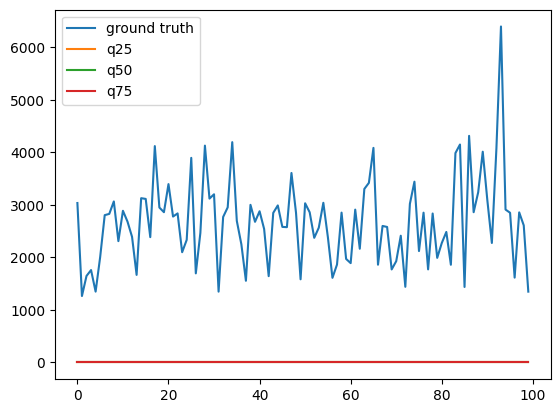

In [143]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [144]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

0.0 0.0 0.0 1.0


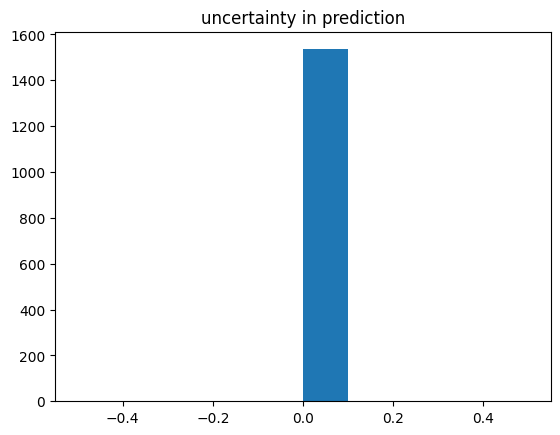

In [145]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

### PREDICTION

In [ ]:
sub.head()

In [ ]:
sub['FVC1'] = 0.996*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [ ]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull()].head(10)

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.head()

In [ ]:
subm.describe().T

In [ ]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)